In [1]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# For graphs
%matplotlib inline

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

/home/lgervasoni/anaconda2/envs/urbansprawl/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import extract_uses.parameters as parameters
import extract_uses.utils as utils

# City to download: Grenoble
city_country = "grenoble_france"#"grenoble_france"
citiesFolder = 'cities/'
# Population count file
popu_count_file = "/home/lgervasoni/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-2000/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2000.tif"

# Get the required cities shapefile
utils.getCityShapefile(citiesFolder, [ city_country ])

# Set input files
parameters.setInputFiles(citiesFolder, city_country, popu_count_file, numberOfCuts = 16)
#parameters.setInputFiles(citiesFolder, city_country, popu_count_file = None, numberOfCuts = 16)

('Existing shapefile for', 'grenoble_france')


In [3]:
import extract_uses.main

extract_uses.main.process()

('Folder already exists. Assumption: Already processed. Only mapping categories and exiting.', 'cities/grenoble_france/')
Complete processing: --- 0.403331450621 minutes ---


In [146]:
import loaders

import extract_uses.utils as utils

uses_shp = citiesFolder+city_country+"/full_uses.shp"
bbox = utils.getBoundingBox(uses_shp)

geo_graph = loaders.load_graph(city_country, bbox)
pois_df = loaders.load_pois(city_country, uses_shp)
#centrality_df = loaders.load_graph_centrality(city_country, geo_graph)
#kde_df = loaders.load_graph_kde(city_country, geo_graph, pois_df)

# Grid KDE
grid_step = 0.1#.0015
categories_kde = loaders.load_grid_kde(city_country, pois_df, bbox = bbox, grid_step = grid_step)

('Bounding box:', [45.113017726416615, 5.573125356566398, 45.243980680751875, 5.9029513504478865])
Querying locally for `['nodes', 'edges']`
Found ['nodes', 'edges'] stored locally
Querying locally for `['pois']`
Found ['pois'] stored locally
Querying locally for `['activity', 'residential', 'total']`
Found ['activity', 'residential', 'total'] stored locally


In [110]:
import kde

import numpy as np
import pandas as pd
from seaborn.distributions import _statsmodels_bivariate_kde
from six import string_types
from sklearn.neighbors.kde import KernelDensity
import statsmodels.nonparametric.api as smnp

#grid_step = .0015
grid_step = .01

def _kde(x, y, grid, option):
    if (option == 1):
        bw_func = smnp.bandwidths.bw_scott #scott
    if (option == 2):
        bw_func = smnp.bandwidths.bw_silverman #silverman   
    #TODO: Check other option; normal_reference: normal reference rule of thumb (default), cv_ml: cross validation maximum likelihood, cv_ls: cross validation least squares
    if (option <= 2):
        kde = smnp.KDEMultivariate([x, y], "cc", [bw_func(x), bw_func(y)])
    if (option == 3):
        kde = smnp.KDEMultive
        ariate([x, y], "cc", 'cv_ml')
    if (option == 4):
        kde = smnp.KDEMultivariate([x, y], "cc", 'cv_ls')    
    return kde.pdf([grid[0].ravel(), grid[1].ravel()]).reshape(grid[0].shape)
def _get_grid_kde(pois,grid,option):
    return _kde(pois['lon'].values, pois['lat'].values, grid, option)
def get_grid_all_kde(pois, bbox, grid_step,option):
    kde_dict = {}
    grid = utils.grid_from_bbox(bbox, grid_step)
    for category, items in pois.groupby(by=['category']):
        kde_dict[category] = pd.DataFrame(_get_grid_kde(items, grid,option))
    kde_dict['total'] = pd.DataFrame(_get_grid_kde(pois, grid,option))
    return kde_dict


### Send bw_func, and cv_ml or cv_ls ?
#http://statsmodels.sourceforge.net/devel/nonparametric.html#kernel-density-estimation

categories_kde_scott = get_grid_all_kde(pois_df,bbox,grid_step, 1)
#categories_kde_silverman = get_grid_all_kde(pois_df,bbox,grid_step, 2)
#categories_kde_cv_ml = get_grid_all_kde(pois_df,bbox,grid_step, 3)
#categories_kde_cv_ls = get_grid_all_kde(pois_df,bbox,grid_step, 4)

#kde_all = [ categories_kde_scott, categories_kde_silverman, categories_kde_cv_ml, categories_kde_cv_ls ]
kde_all = [ categories_kde_scott ]

In [124]:
categories_kde = kde_all[0]

[45.113017726416615, 5.573125356566398, 45.243980680751875, 5.9029513504478865]

In [154]:
print( categories_kde.keys() )
keys = list(map(lambda cat : 'kde_' + str(cat), categories_kde.keys()))

import pandas as pd
dfs = list(map(pd.DataFrame, categories_kde.values()))

ser = pd.Series(categories_kde.values(), index=list(map(str, categories_kde.keys())))
ser.activity

['residential', 'total', 'activity']


,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,1.183227e-02,1.483157e-02,1.874524e-02,2.406748e-02,3.145024e-02,4.165533e-02,5.546074e-02,7.352788e-02,9.625064e-02,1.236206e-01,...,0.050132,0.035995,0.025081,0.017207,0.011920,0.008647,0.006806,0.005882,0.005461,0.005242
1,3.313045e-02,4.105238e-02,5.096693e-02,6.383083e-02,8.083967e-02,1.032699e-01,1.322338e-01,1.683850e-01,2.116373e-01,2.609712e-01,...,0.138259,0.099544,0.069567,0.047882,0.033290,0.024243,0.019150,0.016594,0.015430,0.014821
2,8.281566e-02,1.023123e-01,1.261920e-01,1.562835e-01,1.947202e-01,2.435137e-01,3.039740e-01,3.761035e-01,4.581288e-01,5.463307e-01,...,0.337994,0.243944,0.170901,0.117918,0.082179,0.059968,0.047438,0.041133,0.038251,0.036738
3,1.843221e-01,2.283683e-01,2.819723e-01,3.485839e-01,4.319287e-01,5.350072e-01,6.588483e-01,8.013376e-01,9.565052e-01,1.114597e+00,...,0.731826,0.529294,0.371538,0.256790,0.179178,0.130801,0.103416,0.089567,0.083193,0.079830
4,3.652968e-01,4.557609e-01,5.661832e-01,7.028481e-01,8.720240e-01,1.077897e+00,1.320137e+00,1.591800e+00,1.878331e+00,2.158295e+00,...,1.402136,1.015868,0.714148,0.494076,0.344791,0.251422,0.198328,0.171294,0.158724,0.152062
5,6.459142e-01,8.139072e-01,1.020521e+00,1.276475e+00,1.591648e+00,1.971297e+00,2.411798e+00,2.897188e+00,3.397945e+00,3.873010e+00,...,2.374837,1.723038,1.212547,0.839184,0.585146,0.425658,0.334478,0.287665,0.265631,0.253899
6,1.022439e+00,1.303723e+00,1.652691e+00,2.085985e+00,2.617755e+00,3.253524e+00,3.983521e+00,4.777578e+00,5.583857e+00,6.332959e+00,...,3.552357,2.580231,1.816949,1.257226,0.875212,0.634405,0.495918,0.424146,0.389909,0.371600
7,1.455248e+00,1.879356e+00,2.409400e+00,3.068403e+00,3.874272e+00,4.831020e+00,5.919501e+00,7.090707e+00,8.264790e+00,9.337955e+00,...,4.688475,3.408280,2.400772,1.660084,1.153000,0.832012,0.646247,0.549009,0.501971,0.476716
8,1.871434e+00,2.446914e+00,3.169317e+00,4.066515e+00,5.157964e+00,6.443636e+00,7.892671e+00,9.435595e+00,1.096409e+01,1.234087e+01,...,5.455051,3.967894,2.795000,1.930646,1.337106,0.959794,0.740016,0.623793,0.566777,0.536057
9,2.184353e+00,2.886885e+00,3.769187e+00,4.860260e+00,6.177496e+00,7.714456e+00,9.428671e+00,1.123376e+01,1.300027e+01,1.456789e+01,...,5.590773,4.068198,2.865014,1.976325,1.364275,0.973556,0.744488,0.622114,0.561254,0.528361


In [148]:
print('Keys:',keys)
#print('Dfs:',dfs)

with pd.HDFStore(loaders._generate_file_path(city_country), 'a') as store:
    for key, df in zip(keys, dfs):
        store.put(key, df, format='table')

('Keys:', ['kde_residential', 'kde_total', 'kde_activity'])


In [149]:
import pickle
# TODO: create a `loaders` method for `category_kde`
with open('categories_kde.p', 'wb') as f:
    pickle.dump(categories_kde, f)

In [143]:
bbox_ = [ 0, 0, 1, 1 ]
xx, yy = utils.grid_from_bbox(bbox_,grid_step = 0.5)
# Add to all xx, (xx[1] - xx[0]) /  2 => offset required to be at the centre. Same for yy
print(bbox_)
print('-')
print(xx)
print('-')
print(yy)

AttributeError: 'module' object has no attribute 'grid_from_bbox'

In [ ]:
import numpy as np

USE_normalise_kde = False
USE_normalise_lu_grid = False

def normalise_kde(np_kde):
	""" Input: Numpy matrix of the KDE
	Normalise the gridded KDE; Sum(elements) = 1
	"""
	### Normalise to [0,1] all cells of KDE; sum(elements) = 1
	def applyDiv(x,total):
	    return x/total
	applyNormalisation = np.vectorize(applyDiv)
	norm_kde = applyNormalisation(np_kde, np_kde.sum())
	return norm_kde

def metric_phi(x,y):
    #return abs(x-y)
    return abs(x-y)**0.75 # 1 - () ?...
    #return abs(x-y) * max(x,y)
    #return abs(x-y) * min(1,x+y)
    #return (1 - ( abs(x-y)**0.1 ) ) * min(1,x+y)
    #return (1 - ( abs(x-y)**0.5 ) ) * max(x,y)
def metric_phi_entropy(x,y):
    import math
    #https://www.wolframalpha.com/input/?i=plot+z+%3D+-+(+(+x*ln(x)+)+%2B+(+y*ln(y)+)+)+%2F+ln(2),+x%3D0..1
    return - ( ( x*math.log(x) ) + ( y*math.log(y) ) ) / math.log(2)
def metric_phi_balance_index(x,y):
    #https://www.wolframalpha.com/input/?i=plot+z%3D+1-+(abs(x-y))%2F(x%2By)+,+x%3D0..1
    return 1 - (abs(x-y))/(x+y)

#phi_metric = 'phi_entropy'#'phi','phi_entropy','phi_balance_index'
def compute_landuse_mix(kde_activities, kde_residential, phi_metric = 'phi_entropy'):
	# Convert to numpy matrix
	np_kde_activities = np.matrix(kde_activities)
	np_kde_residential = np.matrix(kde_residential)

	if (USE_normalise_kde):
		np_kde_activities = normalise_kde(np_kde_activities)
		np_kde_residential = normalise_kde(np_kde_residential)

	# Intialize data structure
	lu_mix = np.zeros(shape=kde_activities.shape)
	rows, cols = lu_mix.shape[0] , lu_mix.shape[1]

	# Set function to compute
	function_phi = {'phi_entropy' : metric_phi_entropy, 'phi' : metric_phi, 'phi_balance_index' : metric_phi_balance_index }
	compute_phi = function_phi[phi_metric]

	for i in range(rows): #Rows
		for j in range(cols): #Cols
			lu_mix[i,j] = compute_phi(np_kde_activities[i,j] , np_kde_residential[i,j])

	if (USE_normalise_lu_grid): # Normalise output?
		phi = lu_mix.sum()
		for i in range(rows): #Rows
			for j in range(cols): #Cols
				lu_mix[i,j] /= phi

	return lu_mix


"""
import numpy

#http://stackoverflow.com/questions/9002715/how-to-calculate-the-estimated-joint-probability-distribution-for-the-red-and-gr
#2d histogram gives you the counts, in each cell
(H,redEdges,greedEdges) = numpy.histogram2d(
    norm_kde_act.ravel(),norm_kde_res.ravel(),
    bins= 10#(norm_kde_act.shape[0] * norm_kde_act.shape[1])
)

#divide by the total to get the probability of 
#each cell -> the joint distribution
Prg = H/H.sum()

#sum over the `green` axis to get the `red` marginal (nx1)
Pr = H2d.sum(1)[:,numpy.newaxis]
#sum over the `red` axis to get the `green` marginal (1xn) 
Pg = H2d.sum(0)[numpy.newaxis,:]

# Mutual information ?
"""

In [153]:
import lu_mix

lu_mix_entropy = lu_mix.compute_landuse_mix(ser.activity, ser.residential, phi_metric = 'phi_entropy')
lu_mix_abs = lu_mix.compute_landuse_mix(ser.activity, categories_kde.residential, phi_metric = 'phi')
lu_mix_balance_index = lu_mix.compute_landuse_mix(ser.activity, categories_kde.residential, phi_metric = 'phi_balance_index')

#lu_mix_entropy

AttributeError: 'dict' object has no attribute 'activity'

ValueError: shape mismatch: objects cannot be broadcast to a single shape

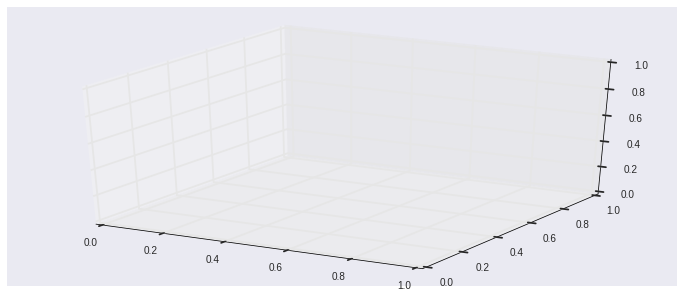

In [151]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import utils
%matplotlib inline
xx, yy = utils.grid_from_bbox(bbox,grid_step)
plot_(xx,yy,lu_mix_abs,'Land use mixity')
plot_(xx,yy,lu_mix_entropy,'Entropy: Land use mixity')
plot_(xx,yy,lu_mix_balance_index,'Balance index: Land use mixity')
plot_(xx,yy,kde_activities,'Activities')
plot_(xx,yy,kde_residential,'Residential')
plt.show()

In [ ]:
# Grid containing num of activities / residential points
# Relative to the total number for each category?

#Act_grid = utils.grid_from_bbox(bbox, grid_step)
#Res_grid = utils.grid_from_bbox(bbox, grid_step)

#Act_grid[0,0]



In [41]:
import numpy as np

""" Plotting functions
Be careful: When x==y
https://www.wolframalpha.com/input/?i=plot+z+%3D+(1+-+abs(x-y)+)*max(x,y),+x%3D0..1
https://www.wolframalpha.com/input/?i=plot+z+%3D+(1+-+abs(x-y)+)*max(x,y)%5E0.5,+x%3D0..1
"""

phi = 0
categories_list = categories_kde.items()
# let: n be the total number of categories; l be the total number of grid (lattice) points
n = len(categories_list[0][0])
l = len(categories_list[0][1])**2 # TODO: more `correct` GRIDSIZE handling
# [[phi += np.sum(vi - vj) for j, (kj, vj) in enumerate(categories_list[i:])] for i, (ki, vi) in enumerate(categories_list)]

for i, (ki, vi) in enumerate(categories_list):
    for j, (kj, vj) in enumerate(categories_list[i:]):
        phi += np.sum(vi - vj) # here i would divide it by l, but computationally i can do that at the end

phi_mix = phi / l # (l * n * (n-1) * .5)

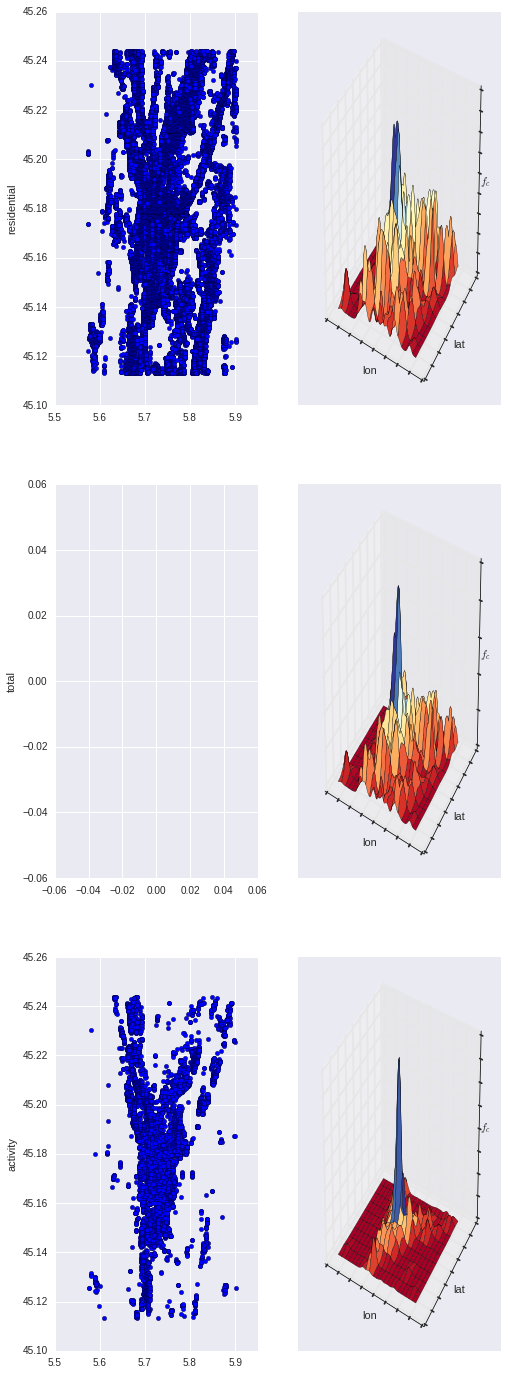

In [51]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import utils

%matplotlib inline
n_rows = len(categories_kde)
base_figsize = 8
xx, yy = utils.grid_from_bbox(bbox,grid_step)

fig = plt.figure(figsize=(8, 8 * n_rows))
i = 1
for categories_kde in kde_all:
    print('---------------')
    for label, z in categories_kde.items():
        category_pois = pois_df[pois_df['category'] == label]
        ax1 = fig.add_subplot(n_rows, 2, i)
        ax2 = fig.add_subplot(n_rows, 2, i+1, projection='3d')
        ax1.scatter(category_pois['lon'], category_pois['lat'])
        ax1.set_ylabel(label, rotation=90)
        ax2.plot_surface(xx, yy, z, cmap=cm.RdYlBu)
        i += 2
        ax2.set_xlabel('lon', labelpad=-10)
        ax2.set_ylabel('lat', labelpad=-10)
        ax2.zaxis.set_rotate_label(False) # workaround
        ax2.set_zlabel(r'$f_c$', rotation=0, labelpad=-15)
        ax2.w_xaxis.set_ticklabels([])
        ax2.w_yaxis.set_ticklabels([])
        ax2.w_zaxis.set_ticklabels([])
    
plt.show()